> **AutoGen > Tutorial > Code Executors**
https://microsoft.github.io/autogen/0.2/docs/tutorial/code-executors


# Code Executors

지난 장에서는 LLM(Large Language Model) 기반의 두 에이전트를 사용해 메시지를 주고받으며 게임을 진행했다. 이번 장에서는 **`코드 실행기(Code executors)`** 를 소개한다. 이 컴포넌트를 통해 에이전트는 단순히 대화만 하는 것이 아니라, 환경과 상호작용하면서 실제로 유용한 계산을 수행하거나 액션을 실행한다.

## Overview

AutoGen에서 `code executor(코드 실행기)`는 **코드 블록이 포함된 메시지를 받아 코드를 실행하고, 그 결과를 포함한 메시지로 응답하는 컴포넌트**이다. 
AutoGen은 두 가지 기본 코드 실행기를 제공한다.

(1) `Command Line Code Executor` (커맨드 라인 코드 실행기)
- UNIX 쉘 같은 커맨드라인 환경에서 코드를 실행한다.

(2) `Jupyetr Executor` (Jupyter 코드 실행기)
- 인터랙티브한 Jupyter 커널(예: Python3)에서 코드를 실행한다.

각 코드 실행기는 **두 가지 방식으로 코드를 실행할수 있다.**

(1) `Local(로컬)`
- AutoGen이 실행중인 운영체제에서 직접 코드를 실행한다.
개발 및 테스트용으로 적합하지만, LLM이 임의로 코드를 생성할 수 있기 때문에 운영환경(프로덕션)에서는 권장되지 않는다.

(2) `Docker(도커)`
- 코드를 도커 컨테이너 내에서 실행한다. 
더 안정한 실행 환경을 제공한다. 

**코드 실행기 종류**

Code Executor(`autogen.coding`) : Environment(Platform)

`LocalCommandLineCodeExecutor` : Shell(Local)
`DockerCommandLineCodeExecutor`: Shell(Docker)
`jupyter.JupyterCodeExecutor`: Jupyter Kernel (e.g., python3)(Local/Docker)

이번 포스팅에서는 **Command line code executors**(커맨드라인 코드 실행기)를 중점으로 작성한다. 
Jupyter Code Executor에 대한 자세한 내용은 User Guide의 Code Execution의 Jupyter Code Executor에서 다시 다룰 예정이다.

## Local Execution

다음 그림은 **`autogen.coding.LocalCommandLineCodeExecutor`**(로컬 커맨드라인 코드 실행기)의 아키텍처를 보여준다.
여기서 주의해야할 점은, LLM이 생성한 코드를 실행하는 것은 호스트 환경에 보안 위험을 초래할 수 있다.
 
 ![](https://velog.velcdn.com/images/heyggun/post/e53477c4-710b-4b00-a83f-b80a8acd57f2/image.png)
 
위 그림을 보자면 에이전트가 코드 실행을 처리하는 내부 구조를 보여주는 다이어그램이다. 즉, LLM 에이전트가 바은 코드 블록을 실제 OS에서 실행하고, 그 결과를 메시지로 다시 반환하는 과정을 설명하고 있다.
단계별로 세부적으로 확인해보자면 

**Local Operating System**은 실제로 코드를 실행하는 환경이다. (bash shell, Python 인터프리터 등)
**Agent**는 사용자와 상호작용하는 LLM 에이전트로, 사용자의 메시지를 받아 코드 실행 요청을 전달하고 결과를 다시 사용자에게 전달한다.
** Code Executor**는 Agent 내부 모듈로, 실제로 코드를 실행하는 주체이다. 코드를 로컬 시스템에 전달하고(`Message with code blocks`), 결과를 읽어와서 Agent에게 넘겨준다(`Message with execution output`).
**Code File**은 실행할 코드가 저장되는 임시 파일로, `Code Executor`가 여기에 코드를 작성하고 이 파일이 OS에서 실행된다.
**Console Output**은 코드 실행 결과가 저장되는 출력 공간으로, 시스템이 코드를 실행한 후 결과는 여기에 저장된다.

즉 정리하자면, **`LocalCommandLineCodeExecutor(로컬 커맨드라인 코드 실행기)`**는 코드 블록이 포함된 메시지를 수신하면

(1) 해당 코드 블록을 코드 파일로 저장하고,
(2) 새로운 서브프로세스를 시작하여 그 코드를 실행한다.
(3) 실행 결과로 생성된 콘솔 출력을 읽어들인 다음,
(4) 이를 응답 메시지로 반환한다.

다음은 `code executor(코드 실행기)`를 사용해 무작위 숫자를 출력하는 python 코드 블록을 실행하는 예시이다.
먼저, 코드 파일을 저장할 **임시 디렉토리**를 사용하는 코드 실행기를 설정한다.
그런 다음, 에이전트를 생성할 때 **`human_input_mode="ALWAYS`** 로 지정하여, 실행 전에 코드의 안정성을 수동으로 검증할 수 있게 한다. 

In [2]:
import tempfile
from autogen import ConversableAgent
from autogen.coding import LocalCommandLineCodeExecutor
from config import settings

api_key = settings.openai_api_key.get_secret_value()

In [5]:
temp_dir = tempfile.TemporaryDirectory()
executor = LocalCommandLineCodeExecutor(
    timeout=10,
    work_dir = temp_dir.name,
)

code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,
    code_execution_config = {"executor" : executor},
    human_input_mode="ALWAYS",
)

In [6]:
!pip install -qqq matplotlib numpy

In [11]:
message_with_code_block = """This is a message with code block.
The code block is below.
```python
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(0, 100, 100)
y = np.random.randint(0, 100, 100)
plt.scatter(x,y)
plt.savefig('scatter.png')
print('Scatter plot saved to scatter.png')
```
This is the end of the message.
"""

messages = [
    {
        "role" : "user",
        "content" : message_with_code_block
    }
]

In [13]:
reply = code_executor_agent.generate_reply(messages=messages)
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to scatter.png



In [15]:
import os

print(os.listdir(temp_dir.name))

['tmp_code_0419e4cc56fbd3c9b9b0181801633ac9.py', 'scatter.png']


In [16]:
temp_dir.cleanup()

In [17]:

print(os.listdir(temp_dir.name))

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/14/q73v_xlx3_x8kr742lgx5_sh0000gn/T/tmp335azswp'

## Doker Execution

LLM에서 생성한 코드를 로컬에서 실행할 때 발생할 수 있는 보안 위험을 완화하기 위해서 **`autogen.coding.DockerCommandLineCodeExecutor`**(도커 코맨드 코드 실행기)를 사용해 코드를 도커 컨테이너 내에서 실행할 수 있다.
이 방식은 생성된 코드가 명시적으로 부여된 리소스에만 접근할 수 있도록 제한해 준다.

아래 그림은 도커 실행 방식이 어떻게 동작하는지를 보여준다.

![](https://velog.velcdn.com/images/heyggun/post/9ac6f542-f821-4895-b423-499d5c6c4bed/image.png)


위 다이어그램은 코드 실행 구조에 Docker 컨테이너를 이용한 격리된 실행 환경을 추가한 구조이다. 즉, 코드를 직접 로컬 OS에서 실행하는 대신, 안전한 Docker 컨테이너 안에서 실행하는 방식이다.

**Agent**는 사용자의 메시지를 수신하고, 코드 실행 요청을 전달하는 주체로 내부에 `Code Executor`를 포함한다. 
**Code Executor**는 코드 블록을 감지하고 실행을 담당하는데, 이때 코드를 로컬 OS에서 직접 실행하지 않고, Docker 컨테이너를 통해 실행하도록 구성한다. Docker 내부 파일 시스템에 쓰고, 실행 결과를 읽어온다. 
**Docker Container** 는 로컬 시스템에서 분리된 격리 실행 환경으로, 보안 의존성 충돌 방지, 언어별 환경 격리에 유리한 장점을 가진다. 컨테이너 내부에는 실행할 코드가 저장되는 `code file`과 코드 실행 결과가 기록되는 콘솔 출력 `Console Output`으로 구성되어 있다.

전체적인 동작 흐름은 사용자의 메시지를 수신하면 Agent가 코드 블록을 추출하고, Code Executor가 코드 파일을 컨테이너 내에서 작성한다. Docker Container에서 코드가 실행되어 Console output에 결과가 저장되고, Code Executor가 Console output을 읽고 Agent는 사용자에게 출력 메시지를 전달하는 것이다. 

local command line code executor(로컬 코맨드라인 코드 실행기)와 유사하게 도커 실행기도 입력 메시지에서 코드 블록을 추출하고 이를 코드 파일로 작성한다. 그리고 각 코드 파일에 대해 도커 컨테이너를 실행시켜 코드를 수행하고, 실행 결과를 콘솔 출력으로부터 읽어들여 메시지로 반환한다.

도커 실행을 사용하려면, 먼저 로컬 머신에 Docker가 설치되어 있고 실행 중이어야 한다. Docker 설치가 완료되었다면, 다음과 같이 코드 실행 에이전트를 설정하여 사용할 수 있다. 

In [22]:
import tempfile
from autogen import ConversableAgent
from autogen.coding import DockerCommandLineCodeExecutor
from config import settings

api_key = settings.openai_api_key.get_secret_value()

In [21]:
temp_dir = tempfile.TemporaryDirectory()

executor = DockerCommandLineCodeExecutor(
    image="python:3.12-slim",
    timeout=10,
    work_dir=temp_dir.name
)


In [23]:
code_executor_agent_using_docker = ConversableAgent(
    "code_executor_agent_docker",
    llm_config=False,
    code_execution_config={"excutor":executor},
    human_input_mode="ALWAYS",
)

## Use Code Execution in Conversation

코드를 작성하고 실행하는 것은 데이터 분석, 머신러닝, 수학적 모델링과 같은 많은 작업에서 필수적이다. AutoGen에서는 `code write agent`(코드 작성 에이전트)와 `code executor agent` (코드 실행 에이전트) 간의 대화를 통해 이 과정을 수행할 수 있다. 이는 마치 프로그래머와 코트 인터프리터 간의 상호작용을 모방한 것과 유사하다. 

아래 그림은 code write agent와 code executor agent가 서로 협력하는 구조를 보여주는 다이어그램이다. 두 개의 에이전트가 역할을 분리해서 하나는 코드 작성, 다른 하나는 실행 및 결과 전달을 맡고 있다. 

![](https://velog.velcdn.com/images/heyggun/post/754a2f86-43d7-4abe-b9c9-b5e85a6b3de6/image.png)

**Code Writer Agent**는 내부에 `LLM`이 탑재되어 있고, 사용자의 요청을 바탕으로 코드를 작성하는 역할을 한다. 작성된 코드를 메시지 형태로 전달한다. 
예를 들어 사용자가 "리스트 안의 수를 제곱해주는 파이썬 코드를 짜줘" 라고 한다면 LLM이 이를 기반으로 코드를 생성한다.

**Code Executor Agent**는 내부에 `Code Executor` 모듈을 포함하고 있고, 전달받은 코드를 실제로 실행하고 결과를 다시 Write Agent에게 반환한다. 

이러한 흐름은 Code Write Agent가 메시지에 포함된 code block을 Code Executor Agent에게 전달하고, Code Executor Agent는 코드를 실행하고 콘솔 출력을 캡처한다. Code Executor Agent는 실행 결과를 Code Writer Agent에게 메시지로 반환하고 이 실행 결과를 사용자에게 보여주거나, 오류 시 수정된 코드로 재작성한다.



In [24]:
code_writer_system_message = """You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when everything is done.
"""

In [26]:
llm_config = {
    "config_list":
        [
            {
                "model" : "gpt-4o-mini",
                "api_key" : api_key
            }
        
        ]
}

In [29]:
temp_dir = tempfile.TemporaryDirectory()
executor = LocalCommandLineCodeExecutor(
    timeout=10,
    work_dir = temp_dir.name,
)

code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,
    code_execution_config = {"executor" : executor},
    human_input_mode="NEVER",
)

In [33]:
code_writer_agent = ConversableAgent(
    "code_write_agent",
    system_message=code_writer_system_message,
    llm_config=llm_config,
    code_execution_config=False
)

In [34]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="14번째 피보나치 수를 계산하는 python 코드를 작성하세요."
)

code_executor_agent (to code_write_agent):

14번째 피보나치 수를 계산하는 python 코드를 작성하세요.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_write_agent (to code_executor_agent):

계산을 위해 14번째 피보나치 수를 구하는 Python 코드를 작성하겠습니다. 피보나치 수열은 각 항이 두 이전 항의 합으로 정의되며, 일반적으로 첫 번째 두 항은 0과 1로 시작합니다.

코드를 아래와 같이 작성할 것입니다:

1. 함수 정의: 피보나치 수를 계산하는 함수를 정의합니다.
2. 14번째 피보나치 수 계산 후 출력합니다.

아래 코드를 실행해 주세요.

```python
# filename: fibonacci.py
def fibonacci(n):
    a, b = 0, 1
    for _ in range(n):
        a, b = b, a + b
    return a

result = fibonacci(14)
print(result)
``` 

코드를 실행하고 결과를 확인해 주세요.

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
code_executor_agent (to code_write_agent):

exitcode: 0 (execution succeeded)
Code output: 377


--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_wri

In [32]:
import os

print(os.listdir(temp_dir.name))

['fibonacci.py']


In [35]:
import datetime

today = datetime.datetime.now().strftime("%Y-%m-%d")
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}. Write Python code to plot TSLA's and META's stock price gains YTD, and save the plot to a file named 'stock_gains.png."
    
    
)

code_executor_agent (to code_write_agent):

Today is 2025-04-16. Write Python code to plot TSLA's and META's stock price gains YTD, and save the plot to a file named 'stock_gains.png.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_write_agent (to code_executor_agent):

To accomplish the task of plotting TSLA's and META's stock price gains year-to-date (YTD), we'll follow these steps:

1. Collect the stock prices for TSLA and META from the start of the year (2025-01-01) to the current date (2025-04-16).
2. Calculate the YTD gains for both stocks.
3. Plot the YTD gains on a bar chart.
4. Save the plot to a file named 'stock_gains.png'.

We'll use the `yfinance` library to fetch the stock data, so the first step will include making sure it is installed. Below is the Python code that performs all the outlined steps:

# filename: plot_stock_gains.py
```python
import yfinance as yf
import matplotlib.pyplot as plt

# Define

In [36]:
import os

print(os.listdir(temp_dir.name))

['tmp_code_febf6dfa2aef99b03ebedb24239a34f5.py', 'stock_gains.png', 'tmp_code_5ea6dbc78fc125a1095688d37610b680.py', 'tmp_code_9fe75abd4e524852d11f3860387d47cb.py', 'tmp_code_d73aeab8864d7a89274773c842c58800.py', 'tmp_code_6343926895289a9c8a4e8981ab98fa17.py', 'fibonacci.py']


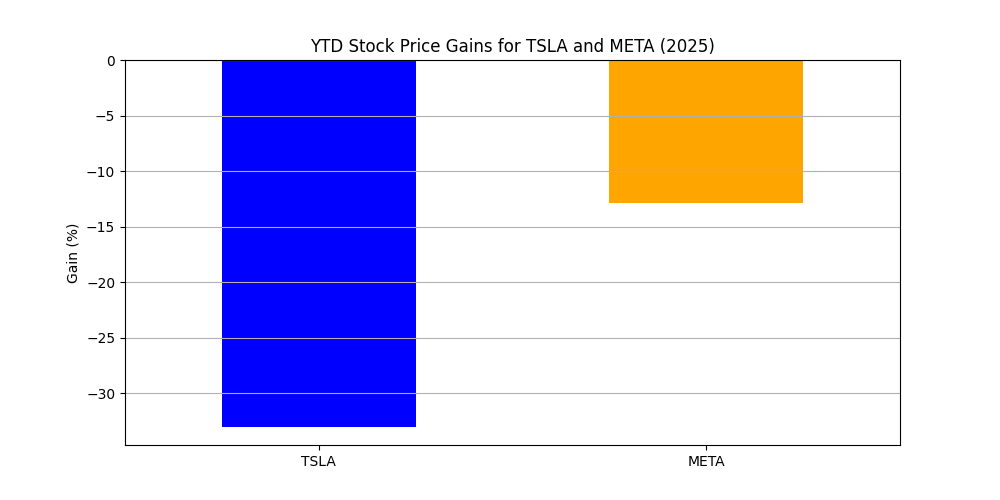

In [40]:
from IPython.display import Image

# 이미지 경로 지정
image_path = os.path.join(temp_dir.name, 'stock_gains.png')

# 이미지 표시
Image(filename=image_path)

In [41]:
temp_dir.cleanup()

## Command Line or Jupyter Code Executor?


`command line code executor` 커맨드 코드 실행기는 서로 다른 코드 블록을 실행할 때마다 메모리에서 상태를 유지하지 않는다. 각 코드 블록은 별도의 파일로 작성되고, 새로운 프로세스에서 코드 블록이 실행되기 떄문이다.
반면 `jupyter code executor`,주피터 코드 실행기는 모든 코드 블록을 동일한 Jupyter 커널에서 실행하므로, 실행 사이에 메모리 상태를 유지한다. 

커맨드 코드 실행기와 Jupyetr 코드 실행기 중 선택은 에이전트의 대화에서 코드 블록의 성격에 따라 다르다. 각 코드 블록이 이전 코드 블록에서 변수를 사용하지 않는 "스크립트" 라면, 커맨드 코드 실행기가 좋은 선택이다. 일부 코드 블록이 머신러닝 모델 훈련이나 대량의 데이터 로딩을 포함하고 반복적인 계산을 피하기 위해 메모리 상태를 유지하고 싶다면 Jupyer 코드 실행기가 더 나은 선택이다.

## Note on User Proxy Agent and Assistant Agent

### User Proxy Agent(사용자 프록시 에이전트)
이전 예시에서는 `ConversableAgent` 클래스를 사용하여 코드 실행 에이전트를 직접 생성했다. 기존의 AutoGen 예시에서는 보통 `UserProxyAgent` 클래스를 사용해서 코드 실행 에이전트를 생성한다. 이 클래스는 `ConversableAgent`의 서브클래스로 `human_input_mode="ALWAYS"` 와 `llm_config=False`가 설정되어 있다. 즉, 이 에이전트는 **모든 메시지에 대해 항상 사용자 입력을 요청하고, LLM을 사용하지 않는다.** 또한 각 `human_input_mode` 설정에 대해 기본적인 설명 필드도 제공한다. 이 클래스는 **코드 실행을 목적으로 사용하는 에이전트를 생성할 때 유용한 간편한 방법이다**


### Assistant Agent(어시스턴트 에이전트)
이전 예시에서는 `ConversableAgent` 클래스를 사용하여 코드 작성 에이전트를 직접 생성했다. 기존의 AutoGen 예시에서는 보통 `AssistantAgent`를 사용해서 코드 작성 에이전트를 생성한다. 이 클래스 역시 `ConversableAgent`의 서브 클래스로 `human_input_mode="NEVER"`와 `code_exeuction_config=False`가 설정되어 있다. 
즉, 이 에이전트는 **사용자 입력을 요청하지 않으며 코드 실행을 사용하지 않는다.** 또한 기본적인 `system_message`와 `description` 필드가 제공된다. 이 클래스는 **코드를 작성하는데 사용되며 코드 실행은 하지 않는 에이전트를 생성할 때 유용한 방법이다.**

사실, 이전 예시에서는 `AssistantAgent` 클래스의 기본 `system_message`필드를 사용하여 코드 작성 에이전트에게 코드 실행 에이전트를 어떻게 사용할지 지시했다.


In [46]:
import pprint
from autogen import AssistantAgent

pprint.pprint(AssistantAgent.DEFAULT_SYSTEM_MESSAGE)

('You are a helpful AI assistant.\n'
 'Solve tasks using your coding and language skills.\n'
 'In the following cases, suggest python code (in a python coding block) or '
 'shell script (in a sh coding block) for the user to execute.\n'
 '    1. When you need to collect info, use the code to output the info you '
 'need, for example, browse or search the web, download/read a file, print the '
 'content of a webpage or a file, get the current date/time, check the '
 'operating system. After sufficient info is printed and the task is ready to '
 'be solved based on your language skill, you can solve the task by yourself.\n'
 '    2. When you need to perform some task with code, use the code to perform '
 'the task and output the result. Finish the task smartly.\n'
 'Solve the task step by step if you need to. If a plan is not provided, '
 'explain your plan first. Be clear which step uses code, and which step uses '
 'your language skill.\n'
 'When using code, you must indicate the scrip

## Best Pratice
`UserProxyAgent`와 `AssistantAgent`는 `ConversableAgent` 클래스에서 `system_message` 지시문을 직접 작성하지 않기 위한 **편의용 단축 클래스**라는 점을 반드시 유의해야 한다.
이 클래스들은 **모든 사용 사례**에 적합하지 않으며, 다음 장에서 보여줄 복잡한 대화 패턴에서는 적절히 동작하지 않을 수 있다.
**복잡한 에이전트 간 대화에서 원하는 동작을 유도하기 위해서는 `system_message` 필드를 정교하게 `조정(tuning)`하는 것이 매우 중요하다.**

가장 좋은 것은, 사용 사례에 맞춰 에이전트의 `system_message`를 **항상 직접 조정**하고, 가능한 `UserPrxyAgent` 및 `AssistantAgent`를 **서브클래싱해서 사용하는 것은 피하는 것이 좋다.**
